<a href="https://colab.research.google.com/github/pedromazim/visao/blob/main/visao_cores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Explorando sistemas de cor

In [ ]:
import numpy as np
from skimage import io
import matplotlib.pyplot as pt
from math import pi

In [ ]:
from numba import jit

In [ ]:
img = io.imread('https://github.com/pedromazim/visao/blob/main/lantana_flower.jpg?raw=true')

(-0.5, 1199.5, 866.5, -0.5)

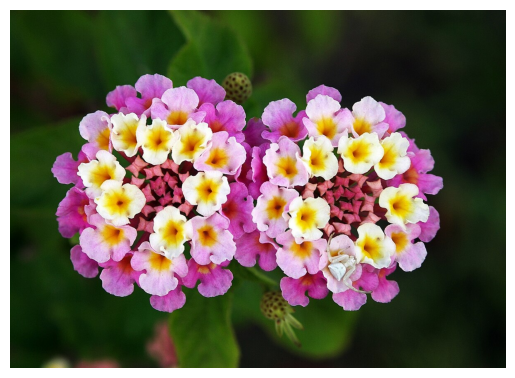

In [ ]:
pt.imshow(img, vmin=0, vmax=255)
pt.axis('off')

In [ ]:
@jit(nopython=False, looplift=True)
def colorscale(img, color_rm, rescale, num_col):

    '''
    changes the number of color shades from an RGB image

    img : grayscale image
    color_rm : vector of colors to be removed from image (R=0, G=1 or B=2)
    rescale : bool
    num_col : number of color bounds in colormap, the number of gray shades is (num_cols-1)

    '''

    thd = np.linspace(0,255,num_col)

    for c in color_rm:
            img[:,:,c] = 0

    if rescale:
        for c in [0,1,2]:
            if c not in color_rm:
                for i in range(img.shape[0]):
                    for j in range(img.shape[1]):
                        for t in range(1,len(thd)-1):
                            if img[i,j, c] <= thd[t] and img[i,j, c] > thd[t-1]:
                                img[i,j,c] = thd[t-1]
                            elif img[i,j,c] >= thd[t] and img[i,j,c] < thd[t+1]:
                                img[i,j,c] = thd[t+1]

    return img

<ipython-input-16-0f4935c8798b>:1: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False, looplift=True)


(-0.5, 1199.5, 866.5, -0.5)

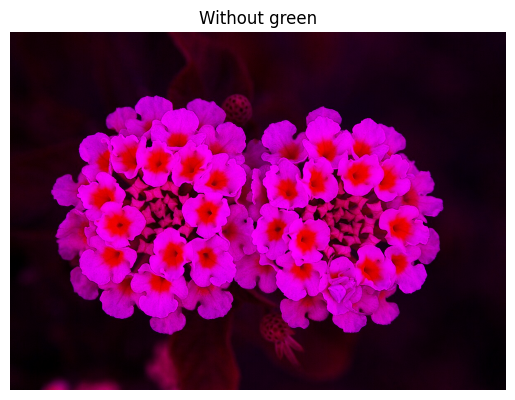

In [ ]:
pt.imshow(colorscale(img, [1], False, num_col), vmin=0, vmax=255)
pt.title('Without green')
pt.axis('off')

(-0.5, 1199.5, 866.5, -0.5)

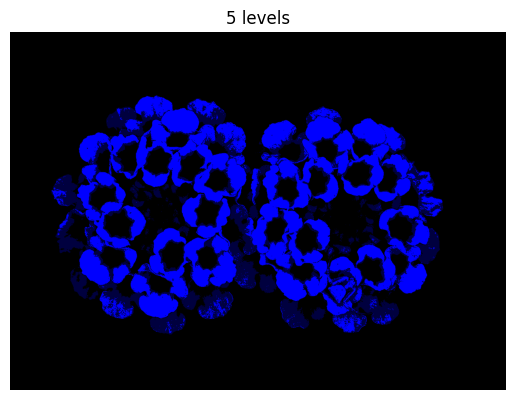

In [ ]:
num_col = 5
pt.imshow(colorscale(img, [0, 1], True, num_col), vmin=0, vmax=255)
pt.title(f'{num_col} levels')
pt.axis('off')

In [ ]:
@jit(nopython=False, looplift=True)
def convert_to_hsi(img):

    '''

    converts and image from RGB to HSI

    conversion formulas available at:
    https://www.rmuti.ac.th/user/kedkarn/impfile/RGB_to_HSI.pdf

    img: RGB format image

    '''

    # auxilliary arrays
    img2 = img.astype(np.float64)
    img_hsi = np.zeros((img.shape[0],img.shape[1],img.shape[2]))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):

            I = np.sum(img2[i,j,:])/(3*255)
            img_hsi[i,j,2] = I*255 # rescales intensity to range [0,255]

            if np.sum(img2[i,j,:]) == 0:
                img2[i,j,:] = [0,0,0]
            else:
                img2[i,j,0] /= np.sum(img2[i,j,:])
                img2[i,j,1] /= np.sum(img2[i,j,:])
                img2[i,j,2] /= np.sum(img2[i,j,:])

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.sum(img2[i,j,:]) == 0:
                H = 0.5*pi
            else:
                if img2[i,j,1] >= img2[i,j,2]:
                    H = np.arccos((0.5*(2*img2[i,j,0]-img2[i,j,1]-img2[i,j,2]))/np.sqrt((img2[i,j,0]-img2[i,j,1])**2 +
                    (img2[i,j,0]-img2[i,j,2])*(img2[i,j,1]-img2[i,j,2])))
                else:
                    H = 2*pi - np.arccos((0.5*(2*img2[i,j,0]-img2[i,j,1]-img2[i,j,2]))/np.sqrt((img2[i,j,0]-img2[i,j,1])**2 +
                    (img2[i,j,0]-img2[i,j,2])*(img2[i,j,1]-img2[i,j,2])))

            S = 1 - 3*np.min(img2[i,j,:])

            img_hsi[i,j,0] = H*(180/pi) # rescales hue to range [0,360]
            img_hsi[i,j,1] = S*100 # rescales saturation to range [0,100]

    return img_hsi.astype(np.uint8)


<ipython-input-19-65cb63f13e1c>:1: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False, looplift=True)


In [ ]:
img_hsi = convert_to_hsi(img)

(-0.5, 1199.5, 866.5, -0.5)

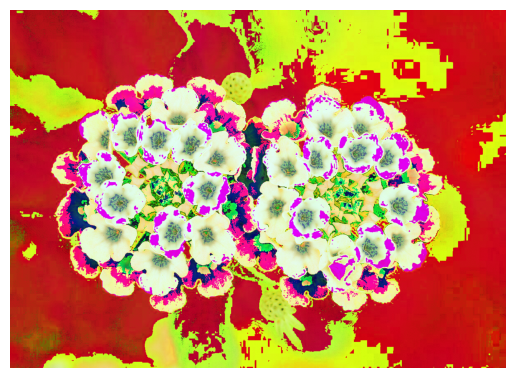

In [ ]:
pt.imshow(img_hsi)
pt.axis('off')

(-0.5, 1199.5, 866.5, -0.5)

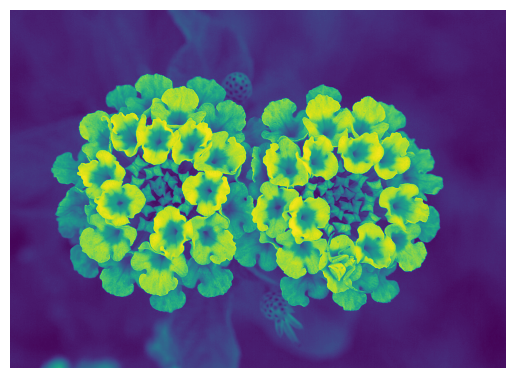

In [ ]:
pt.imshow(img_hsi[:,:,2])
pt.axis('off')

In [ ]:
def rescale_hsi(img, channel, factor):

    '''

    takes an HSI image and rescales a given channel

    img: image in HSI color format
    channel: string with channel to be changed ('H', 'S' or 'I')
    factor: rescaling factor, for hue is a rotation angle (in degrees),
        for other channels is a float

    '''

    if channel == 'H':
        img[:,:,0] = factor-(360-img[:,:,0])
        return img
    elif channel == 'S':
        return np.clip(img[:,:,1]*factor, 0, 100)
    elif channel == 'I':
        return np.clip(img[:,:,2]*factor, 0, 255)

(-0.5, 1199.5, 866.5, -0.5)

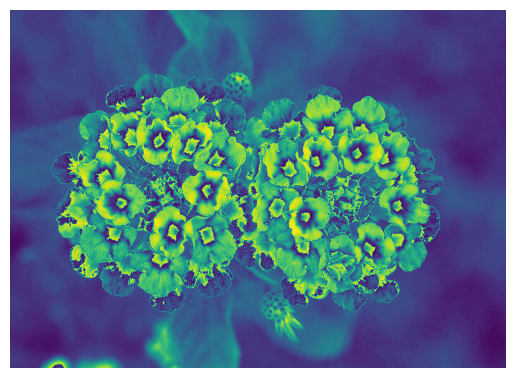

In [ ]:
pt.imshow(rescale_hsi(img_hsi,'I', 2))
pt.axis('off')